## OVO Project : A Simplified Convex Optimization Model for Image Restoration with Multiplicative Noise

**Abdennacer Badaoui**

**abdennacer.badaoui@student-cs.fr**

### Import Libraries

In [ ]:
import os
from typing import Dict, Any, Tuple
import numpy as np
from scipy import ndimage
from scipy import fftpack
import scipy.stats as stats
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

### Model 

In [ ]:
# Helper functions

def forward_d(u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Forward finite difference operator"""
    m, n = u.shape
    dx = np.zeros_like(u)
    dx[:, :-1] = np.diff(u, axis=1)
    dx[:, -1] = u[:, 0] - u[:, -1]
    
    dy = np.zeros_like(u)
    dy[:-1, :] = np.diff(u, axis=0)
    dy[-1, :] = u[0, :] - u[-1, :]
    
    return dx, dy

def dive(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Transpose of the forward finite difference operator"""
    divergence = np.zeros_like(x)
    divergence[:, :] = np.roll(x[:, -1:], 1, axis=1) - x[:, :]
    divergence[:, 1:] -= np.diff(x, axis=1)
    divergence[:, :] += np.roll(y[-1:, :], 1, axis=0) - y[:, :]
    divergence[1:, :] -= np.diff(y, axis=0)
    return divergence

def calculate_psnr(x: np.ndarray, y: np.ndarray) -> float:
    """Calculate PSNR between two images with proper handling of ranges"""
    if x.max() <= 1.0 and y.max() <= 1.0:
        x = x * 255.0
        y = y * 255.0
    
    mse = np.mean((x - y) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_ssim(img1: np.ndarray, img2: np.ndarray) -> float:
    """Calculate SSIM between two images"""
    K = [0.01, 0.03]
    L = 255
    
    window = np.zeros((11,11))
    window[5,5] = 1
    window = ndimage.gaussian_filter(window, sigma=1.5)
    window = window/window.sum()
    
    c1 = (K[0]*L)**2
    c2 = (K[1]*L)**2
    
    mu1 = ndimage.convolve(img1, window, mode='reflect')
    mu2 = ndimage.convolve(img2, window, mode='reflect')
    
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    
    sigma1_sq = ndimage.convolve(img1*img1, window, mode='reflect') - mu1_sq
    sigma2_sq = ndimage.convolve(img2*img2, window, mode='reflect') - mu2_sq
    sigma12 = ndimage.convolve(img1*img2, window, mode='reflect') - mu1_mu2
    
    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma12 + c2))/((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    return float(np.mean(ssim_map))




In [ ]:
# Main algorithm implementation
def cmc(psf: np.ndarray, noisy_image: np.ndarray, original_image: np.ndarray, 
        noise: np.ndarray, mean_w: float, opts: Dict[str, Any]) -> Dict[str, Any]:
    """Main algorithm implementation with fixed PSNR"""
    
    # Extract parameters with new default values
    beta1 = opts.get('beta1', 1.0)
    beta2 = opts.get('beta2', 0.1)
    alpha1 = opts.get('alpha1', 0.01)
    max_iterations = opts.get('max_iterations', 1000)
    tolerance = opts.get('tolerance', 5e-5)
    
    # Normalize input images to [0,1] range for processing
    scale_factor = 255.0
    noisy_image = noisy_image / scale_factor
    original_image_normalized = original_image / scale_factor
    
    m, n = noisy_image.shape
    
    # Initialize variables
    lambda1 = np.zeros((2*m, n))
    lambda2 = np.zeros((m, n))
    restored_image = noisy_image.copy()
    weights = np.zeros((m, n))
    
    grad_x, grad_y = forward_d(noisy_image)
    
    metrics = {
        'ssim_values': [],
        'psnr_values': [],
        'relative_change': [],
        'restoration_error': [],
        'iteration_count': 0,
        'converged': False
    }
    
    relative_change = 1
    current_iteration = 0
    
    while relative_change > tolerance and current_iteration < max_iterations:
        previous_image = restored_image.copy()
        
        # Step 1: Update auxiliary variables
        z1 = grad_x + lambda1[:m,:]/beta2
        z2 = grad_y + lambda1[m:,:]/beta2
        magnitude = np.sqrt(z1**2 + z2**2)
        magnitude[magnitude == 0] = 1
        v = np.maximum(magnitude - alpha1/beta2, 0)/magnitude
        p = np.vstack((z1*v, z2*v))
        
        # Step 2: Update weights
        blurred = ndimage.convolve(restored_image, psf, mode='wrap')
        right_term = mean_w*np.ones((m,n)) + noisy_image*(beta1*blurred + lambda2)
        weights = right_term/(np.ones((m,n)) + beta1*(noisy_image**2))
        
        # Step 3: Update restored image in Fourier domain
        b1_1 = beta2*dive(p[:m,:], p[m:,:])
        b1_2 = -dive(lambda1[:m,:], lambda1[m:,:])
        b1_3 = beta1*ndimage.convolve(noisy_image*weights, psf[::-1,::-1], mode='wrap')
        b1_4 = -ndimage.convolve(lambda2, psf[::-1,::-1], mode='wrap')
        
        b1 = fftpack.fft2(b1_1 + b1_2 + b1_3 + b1_4)
        
        # Modified FFT operations
        psf_freq = fftpack.fft2(psf, shape=(m,n))
        psf_power = np.abs(psf_freq)**2
        grad_power = (np.abs(fftpack.fft2(np.array([[1, -1]]), (m,n)))**2 + 
                     np.abs(fftpack.fft2(np.array([[1], [-1]]), (m,n)))**2)
        
        # Ensure numerical stability
        denominator = beta1*psf_power + beta2*grad_power
        denominator[denominator < 1e-10] = 1e-10
        
        restored_image = np.real(fftpack.ifft2(b1/denominator))
        restored_image = np.clip(restored_image, 0, 1)   
        
        grad_x, grad_y = forward_d(restored_image)
        
        # Calculate metrics using normalized images
        current_psnr = calculate_psnr(restored_image * scale_factor, original_image)
        current_ssim = calculate_ssim(restored_image * scale_factor, original_image)
        relative_change = np.linalg.norm(restored_image - previous_image)/np.linalg.norm(restored_image)
        
        # Store metrics
        metrics['psnr_values'].append(current_psnr)
        metrics['ssim_values'].append(current_ssim)
        metrics['relative_change'].append(relative_change)
        metrics['restoration_error'].append(
            np.linalg.norm(restored_image - original_image_normalized)/np.linalg.norm(original_image_normalized)
        )
        
        
        # Update Lagrange multipliers
        blurred = ndimage.convolve(restored_image, psf, mode='wrap')
        lambda1[:m,:] = lambda1[:m,:] + beta2*(grad_x - p[:m,:])
        lambda1[m:,:] = lambda1[m:,:] + beta2*(grad_y - p[m:,:])
        lambda2 = lambda2 + beta1*(blurred - noisy_image*weights)
        
        current_iteration += 1
    
    # Scale back the restored image to original range
    metrics['solution'] = np.clip(restored_image * scale_factor, 0, 255)
    metrics['iteration_count'] = current_iteration
    metrics['converged'] = relative_change <= tolerance
    
    return metrics

# Function to test the implementation 
def test_cmc(img, L, max_iterations: int = 100):
    """Test the implementation with improved parameters"""
    # Load and prepare test image
    img = img.astype(float)
    m, n = img.shape
    
    # Generate noise
    np.random.seed(42)
    noise_matrix = stats.gamma.rvs(L, scale=1/L, size=(m, n))
    mean_inverse_noise = np.sum(1. / noise_matrix) / (m * n)
    
    # Create and apply blur kernel
    kernel_size = 1  

    psf = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    psf[kernel_size // 2, kernel_size // 2] = 1
    psf = psf / psf.sum()  # Normalize to make sure it's a valid filter
        
    # Create noisy blurred image
    noisy_blurred = ndimage.convolve(img, psf, mode='wrap') * noise_matrix
    
    # New improved parameters
    parameters = {
        'beta1': 1.0,
        'beta2': 0.1,
        'alpha1': 0.1,
        'max_iterations': max_iterations,
        'tolerance': 5e-5
    }
    
    print("Starting restoration...")
    
    # Run algorithm
    results = cmc(psf, noisy_blurred, img, noise_matrix, mean_inverse_noise, parameters)
    
    return noisy_blurred, results
    

# Function to generate results
def experiences(images_list, L_list, max_iterations: int = 100, save_folder="results"):
    os.makedirs(save_folder, exist_ok=True) 

    num_rows = len(images_list) * len(L_list)
    fig = plt.figure(figsize=(15, 5 * num_rows))  
    gs = gridspec.GridSpec(num_rows + 1, 6, figure=fig, height_ratios=[0.3] + [1.5] * num_rows)  

    column_titles = ["Image Name", "L", "Original", "Noisy", "Restored", "PSNR"]
    for j, title in enumerate(column_titles):
        ax = fig.add_subplot(gs[0, j])
        ax.text(0.5, 0.5, title, ha='center', va='center', fontsize=14, fontweight='bold')
        ax.axis('off')

    row = 1  
    for img_path in images_list:
        img_name = os.path.basename(img_path).split('.')[0]  
        for L in L_list:
            image = Image.open(img_path).convert('L')  
            image = np.array(image, dtype=np.float32)  

            noisy_blurred, results = test_cmc(image, L, max_iterations)
            restoration = results['solution']
            psnr = results['psnr_values'][-1]

            # Define image save paths
            image_paths = {
                "original": os.path.join(save_folder, f"{img_name}_L{L}_original.png"),
                "noisy": os.path.join(save_folder, f"{img_name}_L{L}_noisy.png"),
                "restored": os.path.join(save_folder, f"{img_name}_L{L}_restored.png"),
            }

            # Normalize and save images as uint8 PNGs
            for key, img_array in zip(image_paths.keys(), [image, noisy_blurred, restoration]):
                img_uint8 = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
                Image.fromarray(img_uint8).save(image_paths[key])

            text_values = [img_name, f"L = {L}", None, None, None, f"{psnr:.2f}"]
            for j, text in enumerate(text_values):
                ax = fig.add_subplot(gs[row, j])
                if text is not None:
                    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)
                ax.axis('off')

            images = [image, noisy_blurred, restoration]
            for j in range(3):
                ax = fig.add_subplot(gs[row, j + 2])
                ax.imshow(images[j], cmap='gray')
                ax.axis('off')

            row += 1

    plt.subplots_adjust(hspace=0.5, wspace=0.2)  
    plt.show()

**Experiments**

Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...
Starting restoration...


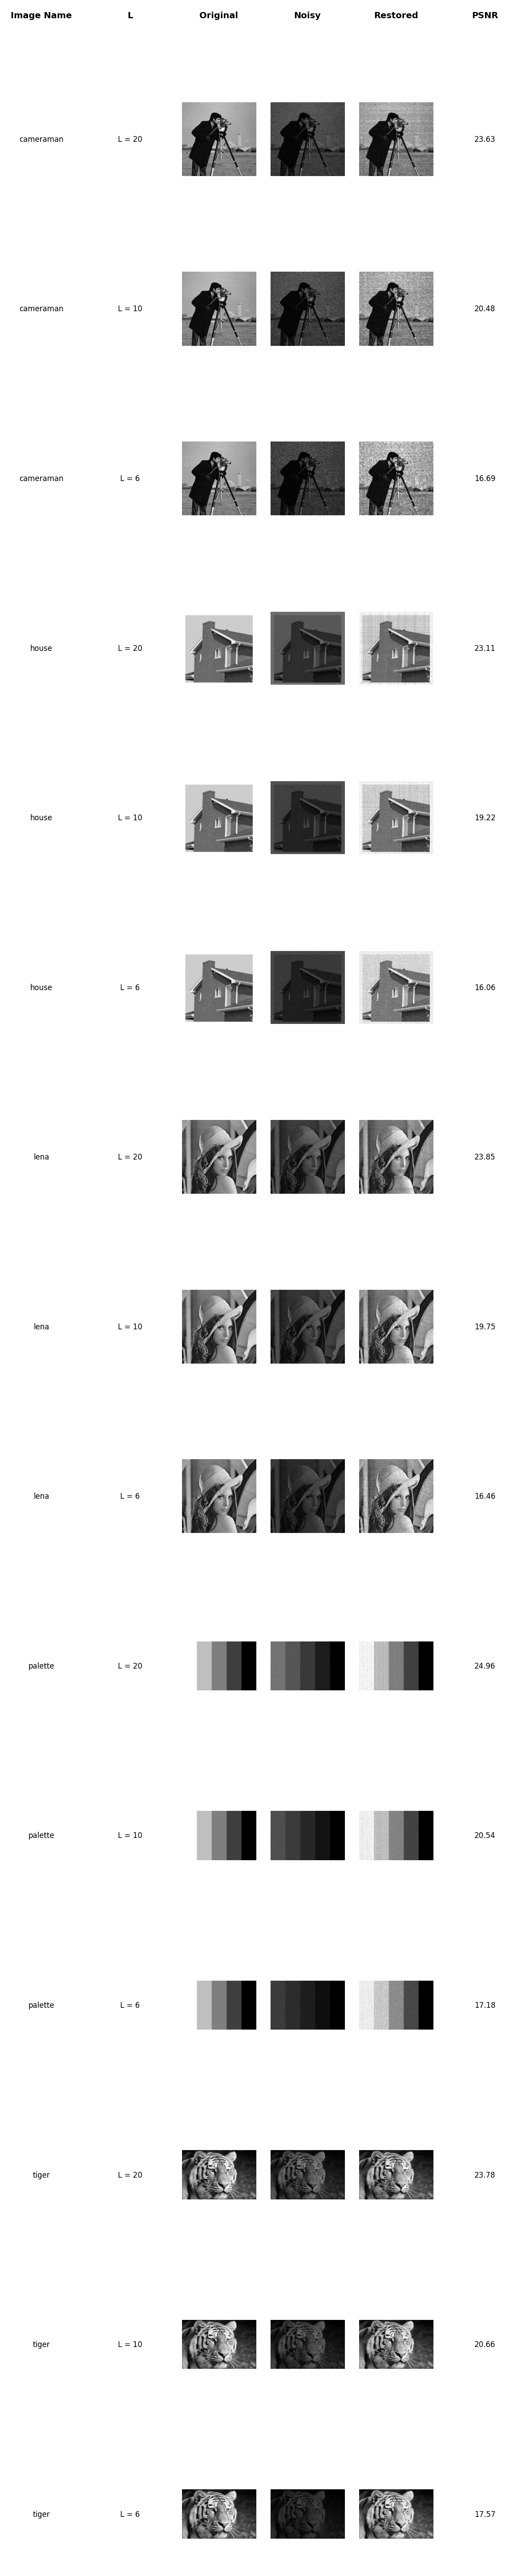

In [ ]:
import os 
images = ["images/" + img for img in os.listdir("images")]
experiences(images, [20, 10, 6], 100)